<a href="https://colab.research.google.com/github/madisonpage050/Chest_X-rays/blob/main/NIHChestX_Rays.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow as tf
tf.__version__

'2.7.0'

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input
import os
import cv2
import numpy as np 
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt 
from random import shuffle , seed
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from tensorflow.keras.applications   import EfficientNetB3
from tensorflow.keras.applications.densenet import DenseNet169
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input ,concatenate, Dense,Flatten , Activation,Conv2D ,Dropout ,MaxPooling2D ,GlobalAveragePooling2D,BatchNormalization

In [ ]:
import pandas as pd
import numpy as np
import os

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/Professional/TKS/NIHChestXRaysSample/sample_labels.csv')
data.head()

# This reads the data for the first 5 columns of the csv file

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y
0,00000013_005.png,Emphysema|Infiltration|Pleural_Thickening|Pneu...,5,13,060Y,M,AP,3056,2544,0.139,0.139
1,00000013_026.png,Cardiomegaly|Emphysema,26,13,057Y,M,AP,2500,2048,0.168,0.168
2,00000017_001.png,No Finding,1,17,077Y,M,AP,2500,2048,0.168,0.168
3,00000030_001.png,Atelectasis,1,30,079Y,M,PA,2992,2991,0.143,0.143
4,00000032_001.png,Cardiomegaly|Edema|Effusion,1,32,055Y,F,AP,2500,2048,0.168,0.168


In [ ]:
Labels_before=data.loc[:,'Finding Labels']
Labels_before.value_counts()

# This gives the number of images in the dataset.

No Finding                                   3044
Infiltration                                  503
Effusion                                      203
Atelectasis                                   192
Nodule                                        144
                                             ... 
Effusion|Infiltration|Mass|Pneumothorax         1
Cardiomegaly|Edema|Infiltration|Pneumonia       1
Consolidation|Fibrosis|Infiltration             1
Atelectasis|Consolidation|Effusion|Mass         1
Atelectasis|Emphysema|Infiltration              1
Name: Finding Labels, Length: 244, dtype: int64

In [ ]:
Labels_after = []

for i in range(len(Labels_before)):
    split_labels=Labels_before[i].split("|")
    if len(split_labels)==1:
            Labels_after.append(split_labels)
    else:
        lab=[]
        for j in range(len(split_labels)):
            lab.append(split_labels[j])
        Labels_after.append(lab)
            
            
Labels_after

[['Emphysema', 'Infiltration', 'Pleural_Thickening', 'Pneumothorax'],
 ['Cardiomegaly', 'Emphysema'],
 ['No Finding'],
 ['Atelectasis'],
 ['Cardiomegaly', 'Edema', 'Effusion'],
 ['Consolidation', 'Mass'],
 ['No Finding'],
 ['No Finding'],
 ['Effusion'],
 ['No Finding'],
 ['Consolidation', 'Effusion', 'Infiltration', 'Nodule'],
 ['Mass'],
 ['No Finding'],
 ['No Finding'],
 ['Effusion'],
 ['Effusion'],
 ['Effusion'],
 ['No Finding'],
 ['Mass', 'Pneumothorax'],
 ['Cardiomegaly', 'Consolidation'],
 ['Consolidation'],
 ['Cardiomegaly', 'Consolidation'],
 ['Cardiomegaly', 'Consolidation'],
 ['Pneumothorax'],
 ['No Finding'],
 ['Effusion'],
 ['Consolidation', 'Pleural_Thickening'],
 ['Infiltration', 'Nodule'],
 ['No Finding'],
 ['Atelectasis'],
 ['Atelectasis'],
 ['Fibrosis'],
 ['Infiltration'],
 ['Infiltration'],
 ['No Finding'],
 ['No Finding'],
 ['No Finding'],
 ['No Finding'],
 ['Fibrosis'],
 ['No Finding'],
 ['Consolidation'],
 ['Emphysema'],
 ['No Finding'],
 ['No Finding'],
 ['Infiltra

In [ ]:
image_size=224
image_file_path="/content/drive/MyDrive/Professional/TKS/NIHChestXRaysSample/images/"
Labels=[]
scans=[]
for i in tqdm(range(len(data["Image Index"]))):
    image=cv2.imread(image_file_path+data["Image Index"][i]) 
    if len(image.shape)>2: # to save images as (heigth , width, 3) rather than (height , width ,4)
      resize_image=cv2.resize(image,(image_size,image_size)) # resize all x-rays as (224 , 224)
      scans.append(resize_image[:,:,:4]) # I assigned labels before into Labels_after list
    else :
      image=np.dstack([image] * 3)
      resize_image=cv2.resize(image,(image_size,image_size)) # resize all x-rays as (224 , 224)
      scans.append(resize_image) # I assigned labels before into Labels_after list

100%|██████████| 5606/5606 [22:34<00:00,  4.14it/s]


In [ ]:
print(set([x.shape for x in scans]))

{(224, 224, 3)}


In [ ]:
len(Labels_after), len(scans)

(5606, 5606)

In [ ]:
def image_show(data, labels , number_of_image ):
    #to generate a random numbers
    numbers=np.random.randint(0,len(data),number_of_image)
    plt.figure(figsize=(40,20))
    j = number_of_image/10
    for _,i in enumerate(numbers):
        plt.subplot(j,10,_+1)
        plt.imshow(data[i] , cmap="gray")
        label=""
        for x in labels[i]:
            label+=x+" , "
        
            
        plt.title(label+"\n"+f"size {data[i].shape}")
        #to remove the number that appear around image
        plt.xticks([]),plt.yticks([])
    plt.show()

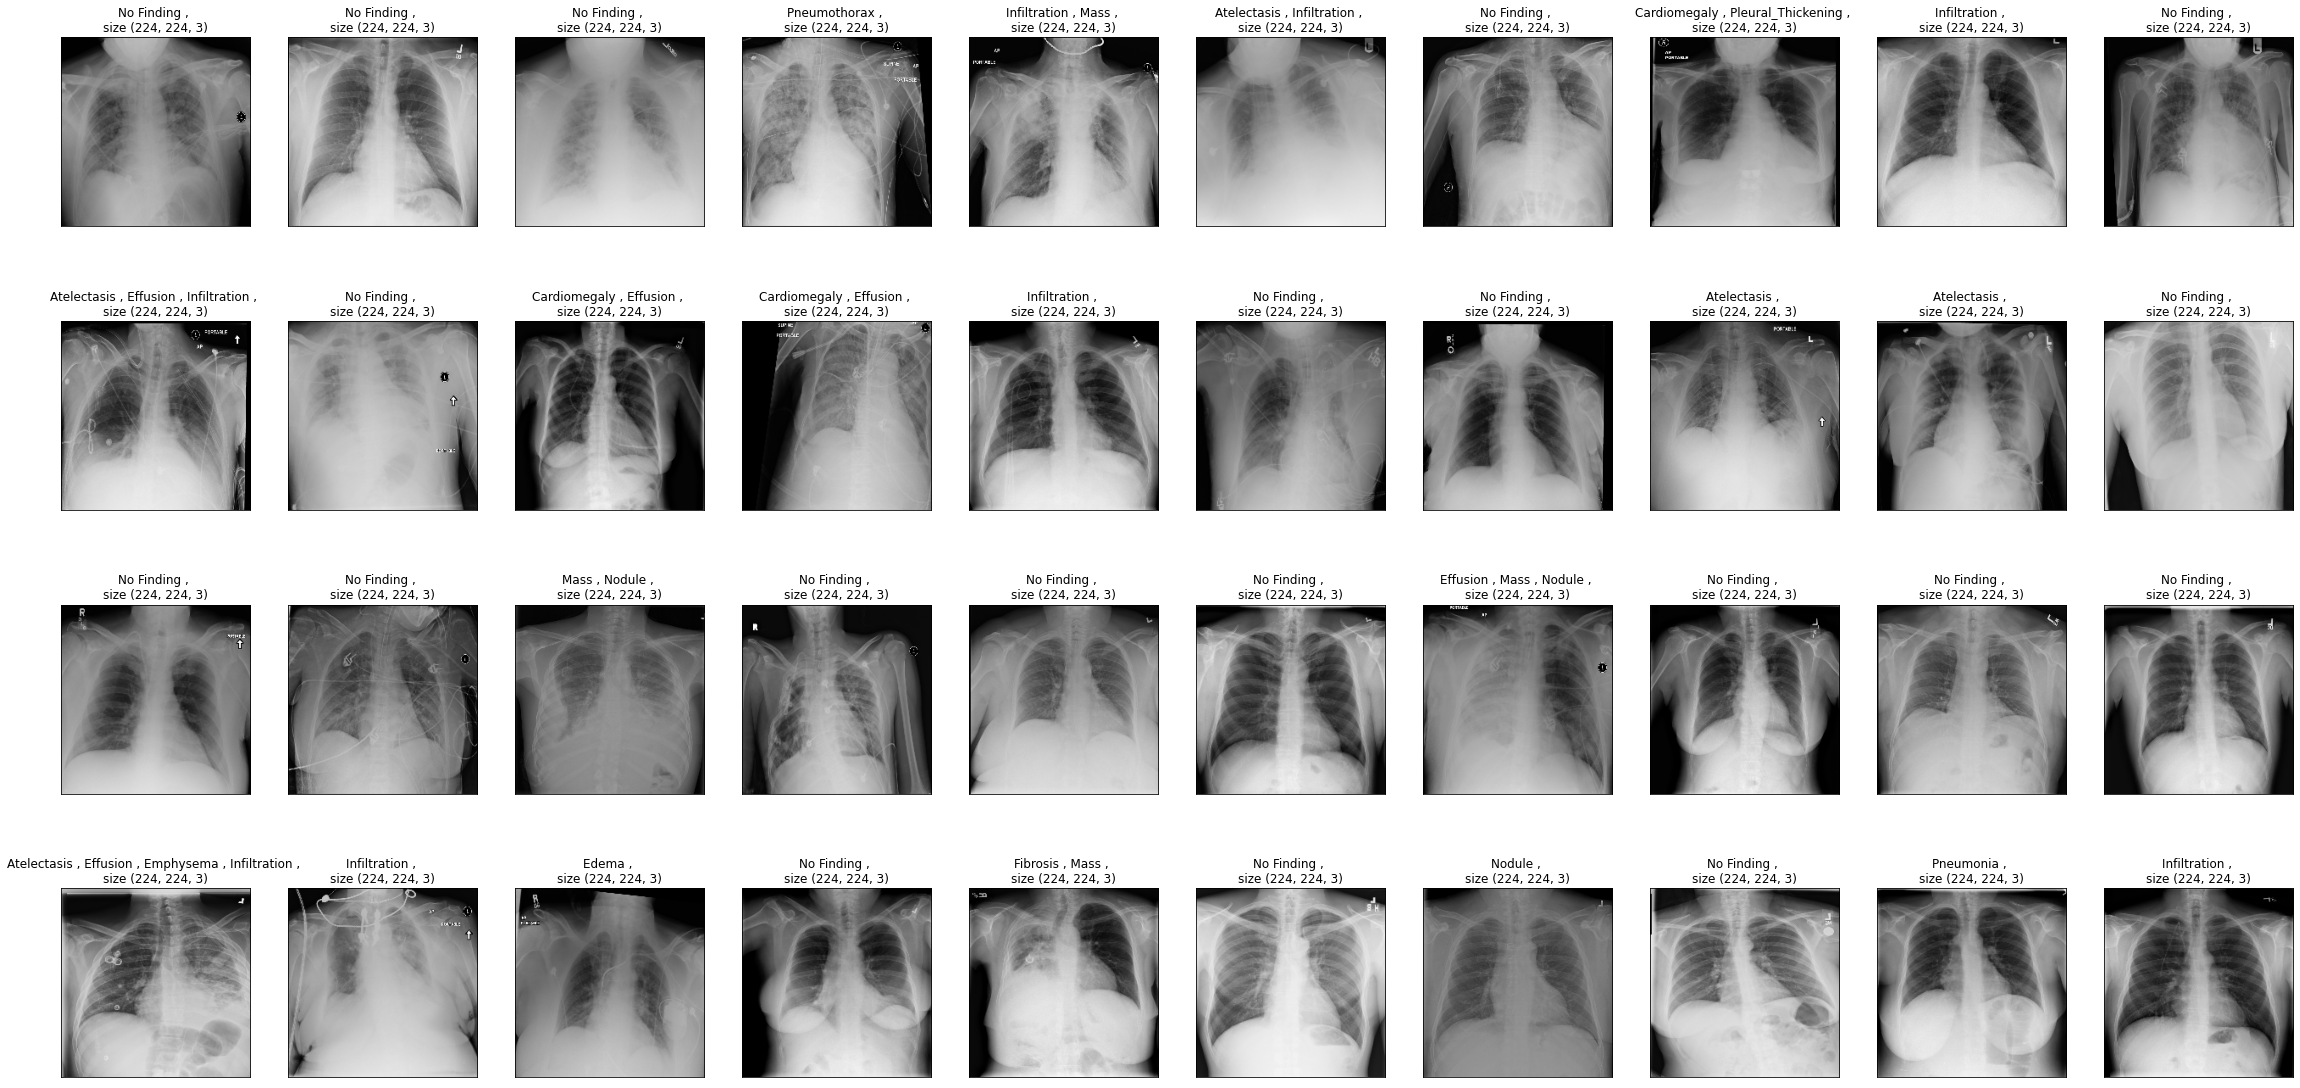

In [ ]:
image_show(scans,Labels_after,40)

In [ ]:
classes={
0:"Hernia",
1:"Pneumonia",
2:"Fibrosis",
3:"Edema",
4:"Emphysema",
5:"Cardiomegaly",
6:"Pleural_Thickening",
7:"Consolidation",
8:"Pneumothorax",
9:"Mass",
10:"Nodule",
11:"Atelectasis",
12:"Effusion",
13:"Infiltration",
14:"No Finding",
}

def get_class(code):
    return classes[code]

def get_code(labels):
    for key,value  in classes.items():
        if value ==labels:
            return key

In [ ]:
for i in tqdm(range(len(Labels_after))):
    Labels_after[i]=[get_code(x) for x in Labels_after[i]]
        

Labels_after

100%|██████████| 5606/5606 [00:00<00:00, 379270.73it/s]


[[4, 13, 6, 8],
 [5, 4],
 [14],
 [11],
 [5, 3, 12],
 [7, 9],
 [14],
 [14],
 [12],
 [14],
 [7, 12, 13, 10],
 [9],
 [14],
 [14],
 [12],
 [12],
 [12],
 [14],
 [9, 8],
 [5, 7],
 [7],
 [5, 7],
 [5, 7],
 [8],
 [14],
 [12],
 [7, 6],
 [13, 10],
 [14],
 [11],
 [11],
 [2],
 [13],
 [13],
 [14],
 [14],
 [14],
 [14],
 [2],
 [14],
 [7],
 [4],
 [14],
 [14],
 [13],
 [7, 9],
 [14],
 [11, 13, 9, 6],
 [13],
 [14],
 [14],
 [13],
 [14],
 [14],
 [14],
 [14],
 [14],
 [14],
 [14],
 [13, 10],
 [14],
 [4],
 [14],
 [13],
 [14],
 [14],
 [8],
 [4, 9],
 [14],
 [14],
 [14],
 [14],
 [14],
 [5, 4],
 [14],
 [14],
 [14],
 [14],
 [14],
 [13],
 [8],
 [4, 8],
 [4, 13],
 [14],
 [14],
 [14],
 [14],
 [13],
 [7, 12, 13],
 [7, 2],
 [14],
 [2, 6],
 [14],
 [14],
 [14],
 [12, 13],
 [2],
 [14],
 [14],
 [14],
 [10],
 [10],
 [9, 6],
 [13, 6],
 [12, 13],
 [14],
 [14],
 [14],
 [9],
 [14],
 [14],
 [14],
 [14],
 [14],
 [9],
 [12],
 [14],
 [14],
 [11],
 [14],
 [6],
 [14],
 [14],
 [14],
 [4],
 [14],
 [14],
 [14],
 [2],
 [14],
 [12],
 [14],

In [ ]:
mlp=MultiLabelBinarizer()
Labels=mlp.fit_transform(Labels_after)
Labels[0],Labels

(array([0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0]),
 array([[0, 0, 0, ..., 0, 1, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 1],
        ...,
        [0, 0, 0, ..., 0, 1, 0],
        [0, 0, 0, ..., 0, 0, 1],
        [0, 0, 0, ..., 0, 0, 1]]))

In [ ]:
scans=np.array(scans)
Labels=np.array(Labels)

In [ ]:
scans.shape, Labels.shape

((5606, 224, 224, 3), (5606, 15))

In [ ]:
!pip install scikit-multilearn
from skmultilearn.model_selection import iterative_train_test_split
#split to train and test
X_train, y_train, X_test, y_test = iterative_train_test_split(scans, Labels, test_size = 0.2 )
#split to train and test
X_val, y_val, X_test, y_test = iterative_train_test_split(X_test, y_test, test_size = 0.7)

     |████████████████████████████████| 89 kB 3.4 MB/s 


In [ ]:
print("X_train shape",X_train.shape)
print("y_train shape",y_train.shape)
print("X_val shape",X_val.shape)
print("y_val shape",y_val.shape)
print("X_test shape",X_test.shape)
print("y_test shape",y_test.shape)

X_train shape (4497, 224, 224, 3)
y_train shape (4497, 15)
X_val shape (328, 224, 224, 3)
y_val shape (328, 15)
X_test shape (781, 224, 224, 3)
y_test shape (781, 15)


In [ ]:
transform = ImageDataGenerator(
rotation_range=20,
width_shift_range=0.1,
height_shift_range=0.1,
shear_range=0.1,
zoom_range=0.1,
horizontal_flip=False,
vertical_flip=True,
fill_mode='nearest')

In [ ]:
batch_size=16                                              
train_transform=transform.flow(X_train,y_train ,batch_size=batch_size)
val_transform=transform.flow(X_val,y_val,batch_size=batch_size)
test_transform=transform.flow(X_test,y_test,batch_size=batch_size)

In [ ]:
train_scans=train_transform.__getitem__(0)[0]
train_labels=train_transform.__getitem__(0)[1]

In [ ]:
inception = InceptionV3(input_shape = (224, 224, 3), weights = "imagenet", include_top =False)

87924736/87910968 [==============================] - 1s 0us/step


In [ ]:
for layer in inception.layers:
  layer.trainable =True

In [ ]:
z = GlobalAveragePooling2D()(inception.output)

In [ ]:
prediction = Dense(len(classes), activation='sigmoid')(z)

In [ ]:
model = Model(inputs=inception.input, outputs=prediction)

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 111, 111, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 111, 111, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                             

In [ ]:
model.compile(
    loss = 'binary_crossentropy',
    optimizer ='adam',
    metrics = ['accuracy'],
    )

In [ ]:
 callbacks = [tf.keras.callbacks.EarlyStopping(monitor="val_loss" , patience=5 , verbose=1)]

In [ ]:
model.fit(X_train, y_train, 
          batch_size=32,
          epochs = 10,
          validation_data=(X_val, y_val),
          verbose=1,
          callbacks = callbacks
          )

Epoch 1/10
141/141 [==============================] - 2148s 15s/step - loss: 0.2026 - accuracy: 0.5281 - val_loss: 0.2485 - val_accuracy: 0.5549
Epoch 2/10
141/141 [==============================] - 2153s 15s/step - loss: 0.1988 - accuracy: 0.5284 - val_loss: 0.2045 - val_accuracy: 0.5488
Epoch 3/10
141/141 [==============================] - 2137s 15s/step - loss: 0.1934 - accuracy: 0.5237 - val_loss: 0.2560 - val_accuracy: 0.5640
Epoch 4/10
141/141 [==============================] - 2136s 15s/step - loss: 0.1892 - accuracy: 0.5348 - val_loss: 0.2130 - val_accuracy: 0.5213
Epoch 5/10
 28/141 [====>.........................] - ETA: 28:17 - loss: 0.1818 - accuracy: 0.5402